# Setup

Ensure all dependencies are installed.


In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Check if we have GPU support, and if not, warn the user.


In [2]:
import torch
import warnings

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    warnings.warn("CUDA is not available. Running on CPU.")

CUDA is available!


Load our dataset...


In [3]:
import tempfile
import os
import zipfile
import shutil

import utils.file

from data_sources import DataSource, ModelNet40
from pointnet.dataset import ModelNetDataset

data_source: DataSource = ModelNet40()
data_size = utils.file.get_download_size(data_source.url)

temp_dir = tempfile.gettempdir()
zip_path = os.path.join(temp_dir, data_source.name + ".zip")
dataset_path = os.path.join(temp_dir, data_source.name)

if os.path.exists(zip_path) and utils.file.checksum(zip_path) == data_source.checksum:
    print("Zip already downloaded.")
else:
    utils.file.download_file(data_source.url, zip_path)
    print("Zip downloaded.")

if os.path.exists(dataset_path):
    print("Conflicting data folder found. Deleting existing folder...")
    shutil.rmtree(dataset_path)
    print("Folder deleted.")

print("Extracting data...")
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(dataset_path)
    print("Data extracted.")

npoints = 2500

train_dataset = ModelNetDataset(root=dataset_path, npoints=npoints, split="train")

test_dataset = ModelNetDataset(
    root=dataset_path,
    split="test",
    npoints=npoints,
)

print(
    f"Training data: {len(train_dataset)} samples with {len(train_dataset.classes)} classes"
)
print(
    f"Test data size: {len(test_dataset)} samples with {len(test_dataset.classes)} classes"
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Zip already downloaded.
Conflicting data folder found. Deleting existing folder...
Folder deleted.
Extracting data...
Data extracted.
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0856.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0092.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0451.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/chair/train/chair_0452.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0458.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0409.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0562.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sofa/train/sofa_0640.off
Fixing OFF file format for /tmp/ModelNet40/ModelNet40/sof

# Training

Train a new classifier or load a new pre-trained one:


In [4]:
from pointnet.train_classification import train_classification
from pointnet.model import PointNetCls

classifier_path = "./pointnet/classifier.pth"

if classifier_path and os.path.exists(classifier_path):
    print(f"Loading existing model from {classifier_path}...")
    classifier = PointNetCls(k=len(train_dataset.classes))
    classifier.load_state_dict(torch.load(classifier_path, weights_only=True))
    print("Classifier loaded successfully.")
else:
    classifier = train_classification(
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        epochs=25,
        outf="./pointnet/cls",
    )

Loading existing model from ./pointnet/classifier.pth...
Classifier loaded successfully.


Run a simple classification to get a visualization of our classifier.


Scores: [-20.19281005859375, -29.815391540527344, -28.631763458251953, -24.892292022705078, -25.94361114501953, -25.61676788330078, -23.271961212158203, -19.615583419799805, -21.530712127685547, -25.070098876953125, -23.392349243164062, -26.98473358154297, -27.48377227783203, -27.802539825439453, -23.24628448486328, -21.74590301513672, -21.019929885864258, -22.091915130615234, -20.168121337890625, -16.048694610595703, -17.157394409179688, -28.20846939086914, -20.26563262939453, -20.71231460571289, -24.91989517211914, -21.930288314819336, -22.137981414794922, -23.024555206298828, -25.746990203857422, -21.297086715698242, -26.410892486572266, -21.03973960876465, -21.504638671875, -22.178516387939453, -1.1920928244535389e-07, -20.64678192138672, -24.167465209960938, -21.958263397216797, -21.5162410736084, -24.212404251098633]
Expected class: monitor (22)
Predicted class: range_hood (34)


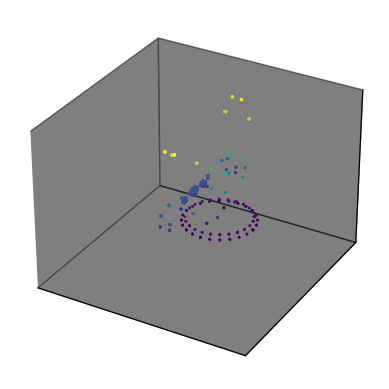

In [12]:
import random
import torch
from utils.plot import plot_points

i = random.randint(0, len(test_dataset) - 1)

input_data = test_dataset[i][0].unsqueeze(0)
input_data = input_data.transpose(1, 2)

classifier.eval()

with torch.no_grad():
    output = classifier(input_data)


scores: torch.Tensor = output[0][0]
print("Scores:", scores.tolist())
print(
    f"Expected class: {test_dataset.classes[int(test_dataset[i][1])]} ({int(test_dataset[i][1])})",
)
print(
    f"Predicted class: {test_dataset.classes[scores.argmax().item()]} ({scores.argmax().item()})"
)

points = input_data[0].transpose(0, 1).numpy()
plot_points(points)

Train the segmenter:


In [ ]:
from pointnet.train_segmentation import train_segmentation

train_segmentation(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    epochs=25,
    class_choice=0,
    outf="./pointnet/seg",
)

Random Seed:  3880


ValueError: Expected input batch_size (80000) to match target batch_size (32).